# Librerias

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


In [2]:
#Librerias
import cudf
import joblib
import cupy as cp
import numpy as np
import os, warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from itertools import cycle
from cuml.manifold import UMAP

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_lfw_people
from sklearn.utils.multiclass import unique_labels
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict

from IPython.display import clear_output
warnings.filterwarnings("ignore")

# Carga de Datos

In [3]:
train = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/train.csv')
test = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/test.csv')

# Análisis del Dataset

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
ytrain = train['Survived']
train = train.drop(['Name', 'Ticket', 'PassengerId','Cabin','Survived'],axis=1)
train.shape

(891, 7)

In [7]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [8]:
encoder_ = OrdinalEncoder()
lista = ['Sex','Embarked']
train[lista]= encoder_.fit_transform(train[lista])
imputer_ = SimpleImputer(strategy='median')
train[['Age','Embarked']]= imputer_.fit_transform(train[['Age','Embarked']])

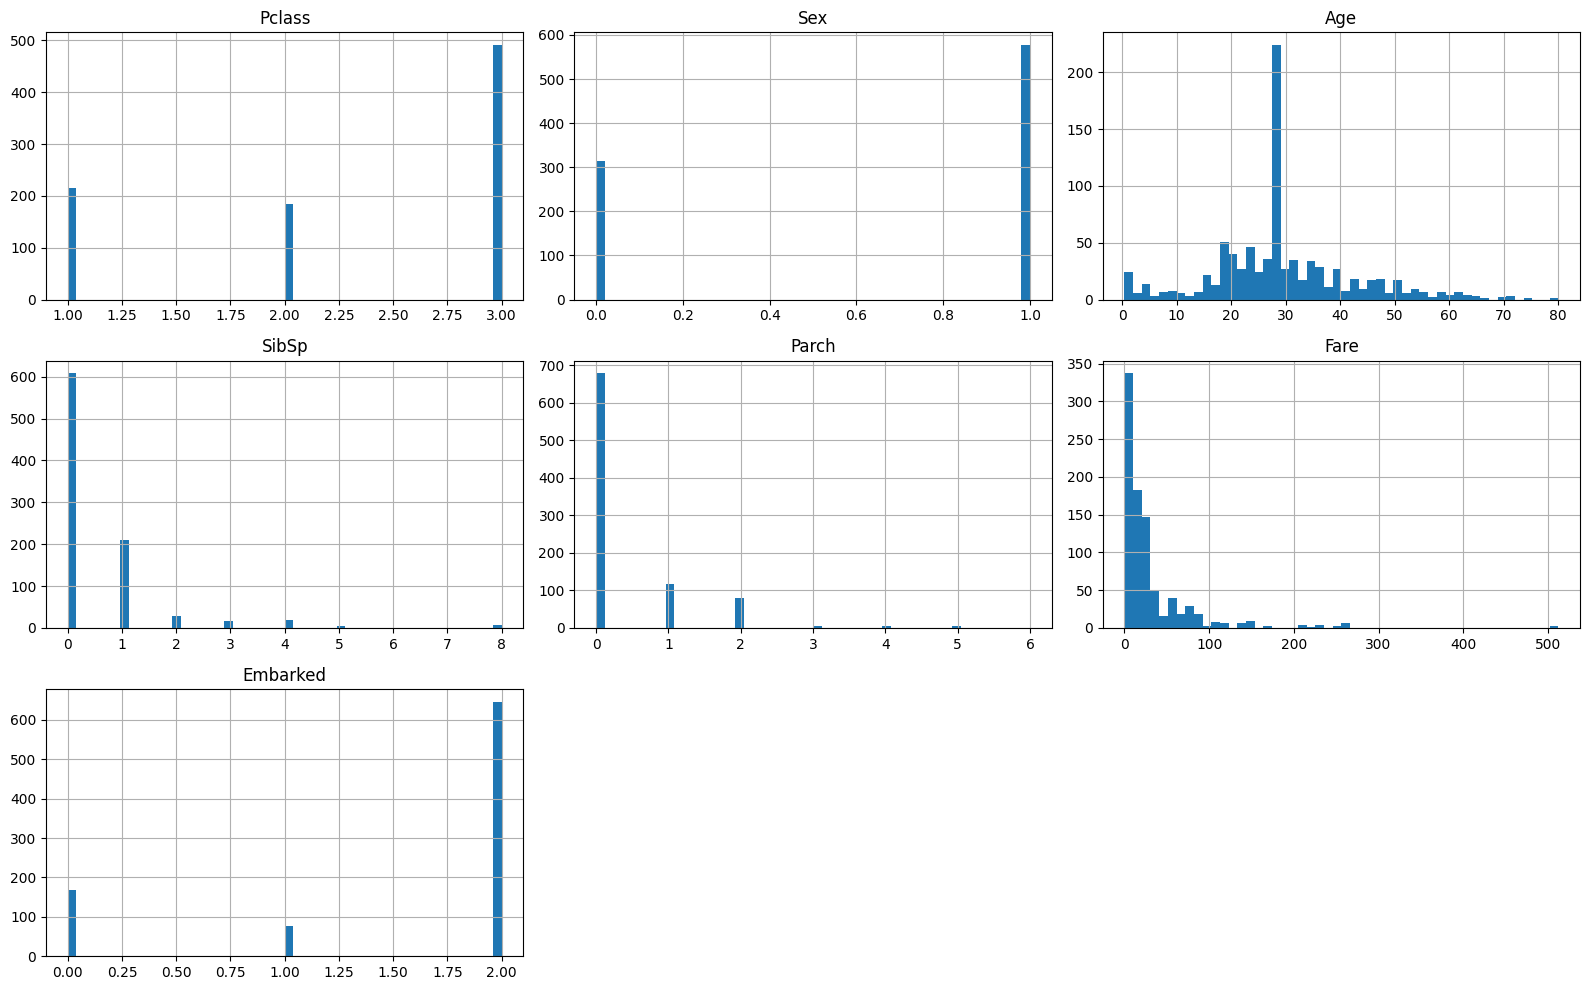

In [9]:
train.hist(bins=50, figsize=(16,10))
plt.tight_layout()
plt.show()

# Reducción de Dimensión con PCA

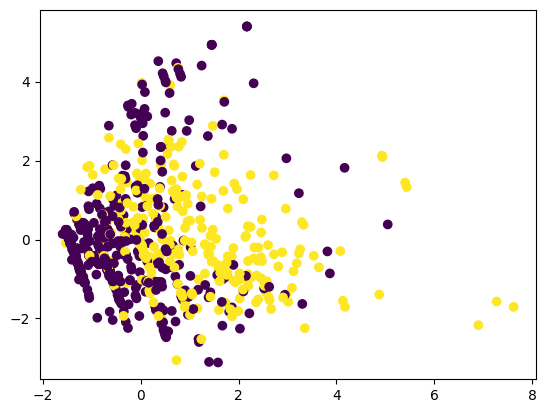

In [10]:
sca_ = StandardScaler()
red_ = PCA(n_components = 2)
ztrain = red_.fit_transform(sca_.fit_transform(train))
ztrain.shape
plt.scatter(ztrain[:,0],ztrain[:,1],c=ytrain)

[2025-10-26 23:19:21.630] [CUML] [info] Building knn graph using brute force


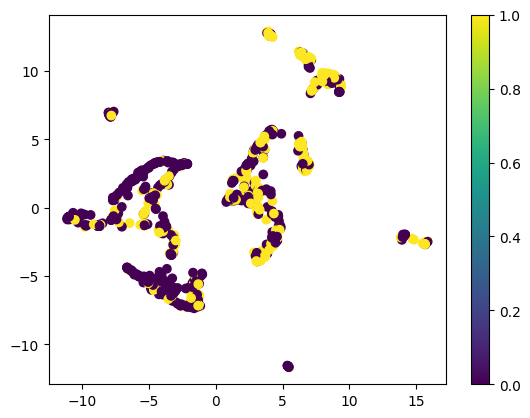

In [11]:
#Utilizando RAPIDS
z = UMAP(n_neighbors=30,n_components=2,min_dist=0.2)
z = z.fit_transform(train)
z = np.asarray(z)
ytrain = np.asarray(ytrain)

plt.scatter(z[:,0],z[:,1],c=ytrain)
plt.colorbar(); plt.show()

# Comparación de Modelos

## Funciones para cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [12]:
# carpeta de resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

# guardar figuras (quita download si no usa Colab)
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

Carpeta results ya existe


In [13]:
def roc_multiclass(y_true, y_score):
    """
    Calcula las curvas ROC y las áreas bajo la curva (AUC) 
    para un problema de clasificación multiclase (One-vs-Rest).

    Parameters
    y_true : ndarray of shape (n_samples, n_classes)
        Etiquetas verdaderas en formato binarizado (one-hot).
    y_score : ndarray of shape (n_samples, n_classes)
        Puntajes predichos o probabilidades de cada clase.

    Returns
    roc_auc : dict
        Diccionario con los valores AUC por clase, además de las claves 'micro' y 'macro'.
    fpr : dict
        Diccionario con los valores de tasa de falsos positivos por clase.
    tpr : dict
        Diccionario con los valores de tasa de verdaderos positivos por clase.
    n_classes : int
        Número total de clases.
    """
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = y_true.shape[1]

    # Curvas ROC individuales
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average (todas las clases combinadas)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

In [14]:
def roc_auc_mc(roc_auc, fpr, tpr, n_classes, title, path_img):
    """
    Grafica las curvas ROC (por clase, micro y macro promedio).

    Parameters
    roc_auc : dict
        Áreas bajo la curva (AUC) por clase y promedios ('micro', 'macro').
    fpr : dict
        Tasas de falsos positivos (FPR) por clase.
    tpr : dict
        Tasas de verdaderos positivos (TPR) por clase.
    n_classes : int
        Número de clases.
    title : str
        Título del gráfico.
    path_img : str, optional
        Ruta donde guardar la imagen (si se desea). Si es None, no se guarda.
    """
    lw = 2
    # Falsos Positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # ROC
    mean_tpr = np.zeros_like(all_fpr)
    # Interpolación y promedio sobre clases
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Gráfica
    plt.figure(figsize=(6, 6))
    plt.plot(
        fpr["micro"], tpr["micro"],
        label=f'Micro-average ROC (AUC = {roc_auc["micro"]:0.2f})',
        color='deeppink', linestyle=':', linewidth=4)

    plt.plot(
        fpr["macro"], tpr["macro"],
        label=f'Macro-average ROC (AUC = {roc_auc["macro"]:0.2f})',
        color='navy', linestyle=':', linewidth=4)

    # Curvas ROC por clase
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label=f'Clase {i} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()

In [15]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    Grafica una curva ROC individual (binaria o promedio).

    Parameters
    fpr : array-like
        Tasa de falsos positivos.
    tpr : array-like
        Tasa de verdaderos positivos.
    label : str, optional
        Etiqueta del gráfico.
    """
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    """
    Grafica una matriz de confusión normalizada (en %).

    Parameters
    y_true : array-like
        Etiquetas verdaderas.
    y_pred : array-like
        Etiquetas predichas.
    classes : array-like
        Lista de nombres o índices de las clases.
    title : str, optional
        Título del gráfico.
    cmap : matplotlib colormap, optional
        Mapa de color a usar para la visualización.

    Returns
    ax : matplotlib.axes.Axes
        Objeto de ejes del gráfico generado.
    """
    if not title:
        title = 'Matriz de Confusión'

    # Calcular matriz normalizada
    cm = 100 * confusion_matrix(y_true, y_pred, normalize="true")
    # Identificación de etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Etiquetas y ejes
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='Etiqueta Verdadera',
        xlabel='Predicción'
    )
    #Rotar Ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Textos
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Entrenamiento y Evaluación (GridSearchCV)

In [17]:
#Partición Entrenamiento y Evaluación (70% Xtrain, 30% Xtest)
Xtrain, Xtest, ytrain,ytest = train_test_split(train,ytrain,test_size=0.3, random_state=123)
Xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
416,2,0.0,34.0,1,1,32.5000,2.0
801,2,0.0,31.0,1,1,26.2500,2.0
512,1,1.0,36.0,0,0,26.2875,2.0
455,3,1.0,29.0,0,0,7.8958,0.0
757,2,1.0,18.0,0,0,11.5000,2.0


In [18]:
#Búsqueda de Parámetros utilizando GridSearchCV
# Definición de Pipelines (Listas de steps)
steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],                   # 1. Logistic
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],                        # 2. SGD
    [('nor', MinMaxScaler()), ('cla', SVC())],                                  # 3. SVC
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],                 # 4. KNeighbors
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],                           # 5. GaussianNB
    [('nor', MinMaxScaler()), ('cla', LDA())],                                  # 6. LinearDiscriminantAnalysis
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier(random_state=42))] # 7. Random Forest
]

# Hiperparámetros asociados
parameters = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},     # 1. Logistic Regression
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]}, # 2. SGD
    {
        'cla__C': [1, 10, 1e2, 1e3],
        'cla__gamma': [1e-3, 1e-2, 1e-1, 1, 10]},        # 3. SVC
    {'cla__n_neighbors': [1, 3, 5, 7, 9, 11]},           # 4. KNeigbhors
    # 5. GaussianNB (no tiene hiperparámetros principales relevantes)  
    {},
    {'cla__solver': ['svd', 'lsqr', 'eigen']},           # 6. LinearDiscriminantAnalysis
    {
        'cla__n_estimators': [50, 100, 200],
        'cla__max_depth': [None, 5, 10, 20]}             # 7. Random Forest
]

# Etiquetas para referencia
label_models = [
    'MinMax_Logistic','MinMax_SGD','MinMax_SVCrbf','MinMax_KNeighbors',
    'MinMax_GaussianNB','MinMax_LDA','MinMax_RandomForest']

models = []
filename_grid = 'results/titanic_models.pkl'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")
    clear_output()

### Rendimientos utilizando validación cruzada

In [19]:
#Encontrar rendimiento más alto sobre CV del gridsearch en test
ind = models[2].cv_results_['mean_test_score'].argmax()
models[i].cv_results_['mean_test_score'][i]

0.8042193548387097

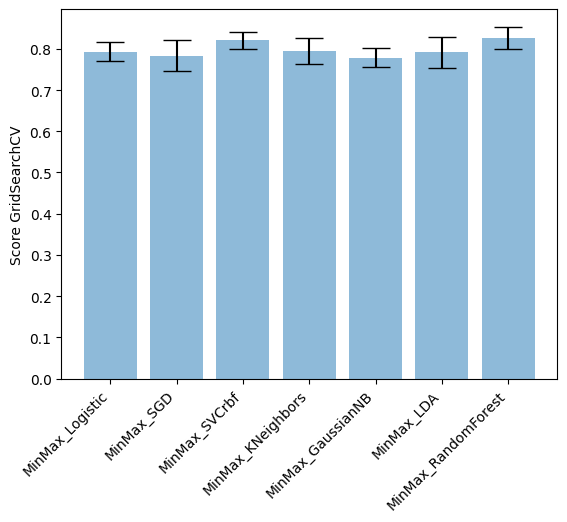

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_KNeighbors', 'MinMax_GaussianNB', 'MinMax_LDA', 'MinMax_RandomForest']
[[0.793 0.783 0.82  0.795 0.779 0.791 0.827]
 [0.023 0.038 0.02  0.031 0.024 0.038 0.027]]


In [20]:
#Recorrer modelos
bars_ = np.zeros((2,len(models))) #arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)),labels=label_models, rotation=45, ha='right')
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))


Evaluando modelo MinMax_Logistic (1/7)
Accuracy: 0.791


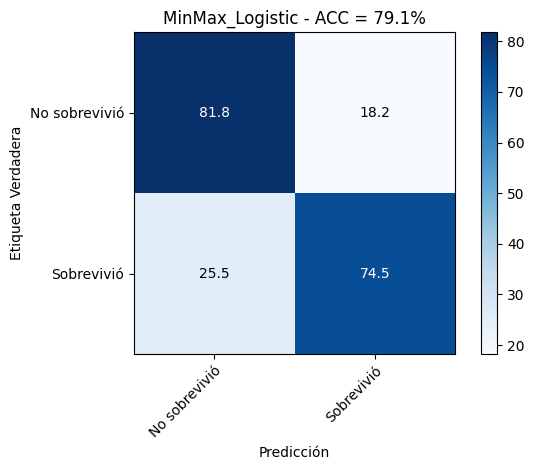

               precision    recall  f1-score   support

No sobrevivió       0.85      0.82      0.83       170
   Sobrevivió       0.70      0.74      0.72        98

     accuracy                           0.79       268
    macro avg       0.77      0.78      0.78       268
 weighted avg       0.79      0.79      0.79       268

No se pudo calcular la ROC para MinMax_Logistic: name 'binary_task' is not defined

Evaluando modelo MinMax_SGD (2/7)
Accuracy: 0.799


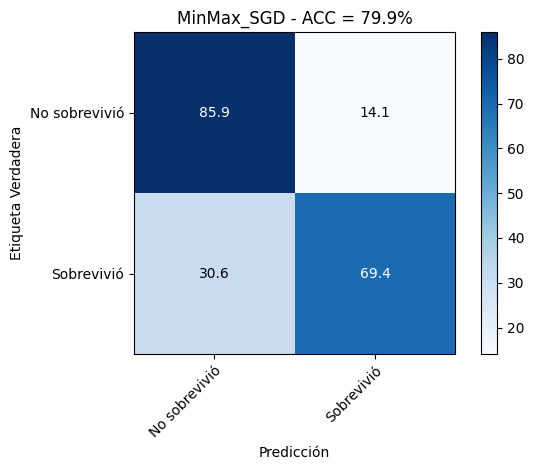

               precision    recall  f1-score   support

No sobrevivió       0.83      0.86      0.84       170
   Sobrevivió       0.74      0.69      0.72        98

     accuracy                           0.80       268
    macro avg       0.78      0.78      0.78       268
 weighted avg       0.80      0.80      0.80       268

No se pudo calcular la ROC para MinMax_SGD: name 'binary_task' is not defined

Evaluando modelo MinMax_SVCrbf (3/7)
Accuracy: 0.840


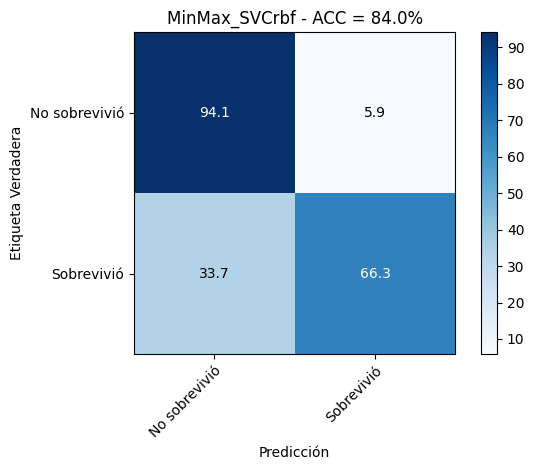

               precision    recall  f1-score   support

No sobrevivió       0.83      0.94      0.88       170
   Sobrevivió       0.87      0.66      0.75        98

     accuracy                           0.84       268
    macro avg       0.85      0.80      0.82       268
 weighted avg       0.84      0.84      0.83       268

No se pudo calcular la ROC para MinMax_SVCrbf: name 'binary_task' is not defined

Evaluando modelo MinMax_KNeighbors (4/7)
Accuracy: 0.810


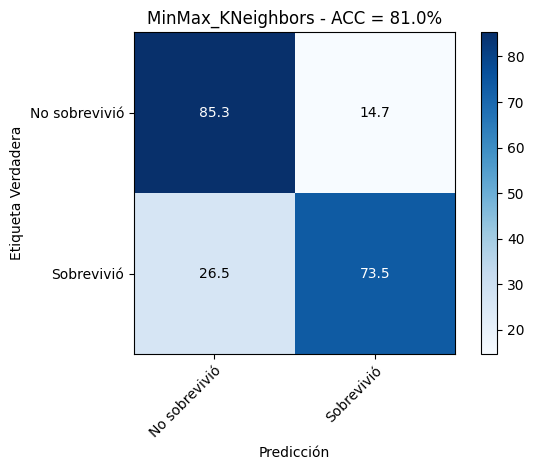

               precision    recall  f1-score   support

No sobrevivió       0.85      0.85      0.85       170
   Sobrevivió       0.74      0.73      0.74        98

     accuracy                           0.81       268
    macro avg       0.80      0.79      0.79       268
 weighted avg       0.81      0.81      0.81       268

No se pudo calcular la ROC para MinMax_KNeighbors: name 'binary_task' is not defined

Evaluando modelo MinMax_GaussianNB (5/7)
Accuracy: 0.810


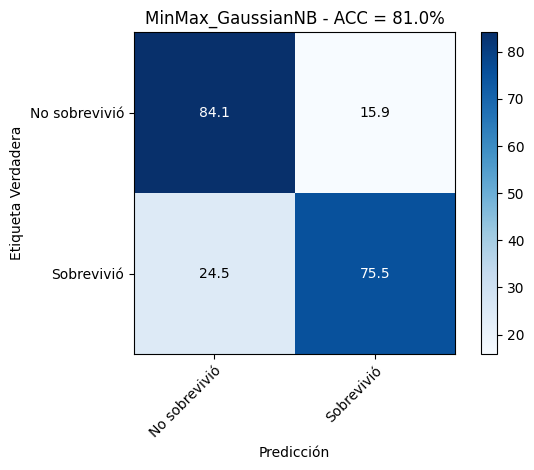

               precision    recall  f1-score   support

No sobrevivió       0.86      0.84      0.85       170
   Sobrevivió       0.73      0.76      0.74        98

     accuracy                           0.81       268
    macro avg       0.79      0.80      0.80       268
 weighted avg       0.81      0.81      0.81       268

No se pudo calcular la ROC para MinMax_GaussianNB: name 'binary_task' is not defined

Evaluando modelo MinMax_LDA (6/7)
Accuracy: 0.802


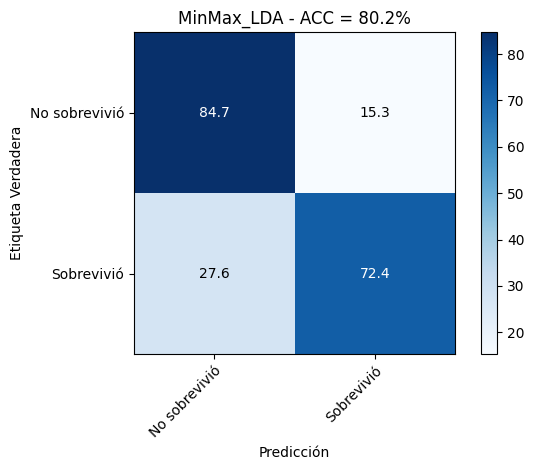

               precision    recall  f1-score   support

No sobrevivió       0.84      0.85      0.84       170
   Sobrevivió       0.73      0.72      0.73        98

     accuracy                           0.80       268
    macro avg       0.79      0.79      0.79       268
 weighted avg       0.80      0.80      0.80       268

No se pudo calcular la ROC para MinMax_LDA: name 'binary_task' is not defined

Evaluando modelo MinMax_RandomForest (7/7)
Accuracy: 0.840


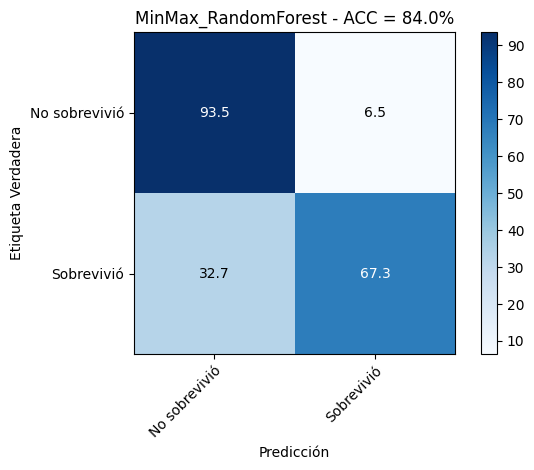

               precision    recall  f1-score   support

No sobrevivió       0.83      0.94      0.88       170
   Sobrevivió       0.86      0.67      0.75        98

     accuracy                           0.84       268
    macro avg       0.84      0.80      0.82       268
 weighted avg       0.84      0.84      0.83       268

No se pudo calcular la ROC para MinMax_RandomForest: name 'binary_task' is not defined


In [21]:
# Evaluar sobre Xtest
# Cargar modelos
my_model_loaded = joblib.load('results/titanic_models.pkl')
n_models = len(my_model_loaded)

# Clases
unique_classes = np.unique(ytest)
class_names = np.array(['No sobrevivió', 'Sobrevivió'])

# Binarizar etiquetas (solo si multiclase o para ROC)
ytrain_b = label_binarize(ytrain, classes=unique_classes)
ytest_b = label_binarize(ytest, classes=unique_classes)

# Evaluación general
for i, model in enumerate(my_model_loaded):
    name = label_models[i] if i < len(label_models) else f"Modelo_{i+1}"
    print(f"\nEvaluando modelo {name} ({i+1}/{n_models})")

    best_est = model.best_estimator_
    
    # === PREDICCIÓN ===
    y_pred = best_est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)
    print(f"Accuracy: {acc:.3f}")

    # === MATRIZ DE CONFUSIÓN ===
    plot_confusion_matrix(
        ytest, y_pred,
        classes=class_names,
        title=f"{name} - ACC = {100*acc:.1f}%")
    plt.show()

    # === REPORTE DE CLASIFICACIÓN ===
    print(classification_report(
        ytest, y_pred,
        target_names=class_names))

    # === CURVA ROC ===
    try:
        if hasattr(best_est, "predict_proba"):
            y_score = best_est.predict_proba(Xtest)
        elif hasattr(best_est, "decision_function"):
            y_score = best_est.decision_function(Xtest)
        else:
            raise AttributeError("Modelo no soporta predict_proba ni decision_function.")

        if binary_task:
            # Binario
            if y_score.ndim > 1:
                y_score = y_score[:, 1]
            fpr, tpr, _ = roc_curve(ytest, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6,6))
            plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label=f'ROC (área = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title(f"ROC Curve - {name}")
            plt.legend(loc="lower right"); plt.show()
        else:
            # Multiclase
            roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, y_score)
            roc_auc_mc(roc_auc, fpr, tpr, n_classes, f'ROC curve {name}', path_img)
    except Exception as e:
        print(f"No se pudo calcular la ROC para {name}: {e}")

## Entrenamiento y Evaluación (BayesSearchCV)

In [22]:
!pip install scikit-optimize
clear_output()

In [23]:
steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],                   # 1. Logistic
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],                        # 2. SGD
    [('nor', MinMaxScaler()), ('cla', SVC())],                                  # 3. SVC
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],                 # 4. KNeighbors
    [('nor', MinMaxScaler()), ('cla', LDA())],                                  # 5. LinearDiscriminantAnalysis
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier(random_state=42))] # 6. Random Forest
]

# Espacios de búsqueda para BayesSearchCV
search_spaces = [
    { 'cla__C': Real(1e-3, 1e3, prior='log-uniform') },         # 1. Logistic Regression
    { 'cla__alpha': Real(1e-3, 1e3, prior='log-uniform') },    # 2. SGD
    { 
        'cla__C': Real(1, 1e3, prior='log-uniform'),
        'cla__gamma': Real(1e-3, 10, prior='log-uniform')},    # 3. SVC
    { 'cla__n_neighbors': Integer(1, 15) },                    # 4. KNeighbors
    { 'cla__solver': Categorical(['svd', 'lsqr', 'eigen']) },  # 5. LDA
    {
        'cla__n_estimators': Integer(50, 300),
        'cla__max_depth': Integer(3, 30)}                      # 6. Random Forest
]

# Etiquetas para referencia
label_models = ['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf',
                'MinMax_KNeighbors','MinMax_LDA', 'MinMax_RandomForest']

# Carpeta para guardar resultados
os.makedirs("results", exist_ok=True)
filename = 'results/titanic_models'
models = []

# Entrenamiento con BayesSearchCV
for i in range(len(steps)):
    print(f"Modelo {i+1}/{len(steps)}: {label_models[i]}")

    bayes_search = BayesSearchCV(
        estimator=Pipeline(steps[i]),search_spaces=search_spaces[i],
        n_iter=30,cv=5,scoring='accuracy',n_jobs=-1,refit=True,
        verbose=2,random_state=42)
    bayes_search.fit(Xtrain, ytrain)
    models.append(bayes_search)
    joblib.dump(models, filename + ".pkl")
    print(f"Modelo {label_models[i]} optimizado y guardado.")
    clear_output()

### Evaluación de modelos BayesSearchCV

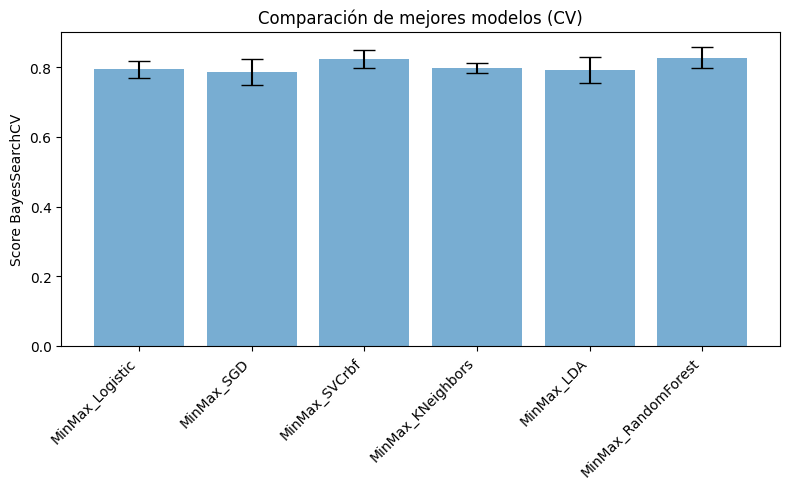

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_KNeighbors', 'MinMax_LDA', 'MinMax_RandomForest']
[[0.795 0.787 0.825 0.799 0.791 0.828]
 [0.025 0.038 0.026 0.014 0.038 0.031]]


In [24]:
# Cargar modelos entrenados
my_model_loaded = joblib.load('results/titanic_models.pkl')
n_models = len(my_model_loaded)

# Calcular mejores scores promedio (CV)
bars_ = np.zeros((2, n_models))
for i in range(n_models):
    results = my_model_loaded[i].cv_results_
    ind = results['mean_test_score'].argmax()
    bars_[0, i] = results['mean_test_score'][ind]
    bars_[1, i] = results['std_test_score'][ind]

#Gráfica comparativa de scores
plt.figure(figsize=(8, 5))
plt.bar(np.arange(n_models), bars_[0],yerr=bars_[1],
    align='center', alpha=0.6, ecolor='black', capsize=8)
plt.ylabel('Score BayesSearchCV')
plt.xticks(np.arange(n_models), labels=label_models, rotation=45, ha='right')
plt.title('Comparación de mejores modelos (CV)')
plt.tight_layout(); plt.show()
print(label_models); print(np.round(bars_, 3))


Evaluando modelo MinMax_Logistic (1/6)
Accuracy: 0.791


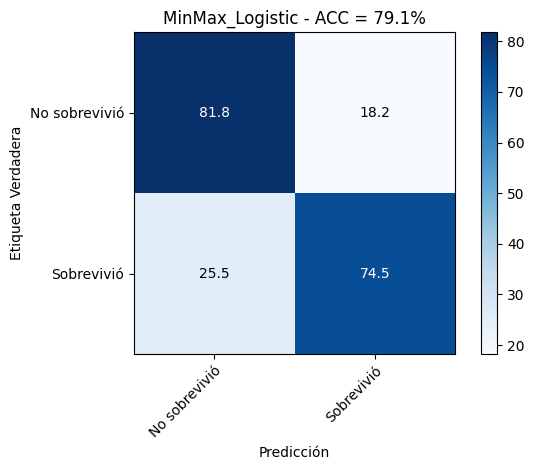

               precision    recall  f1-score   support

No sobrevivió       0.85      0.82      0.83       170
   Sobrevivió       0.70      0.74      0.72        98

     accuracy                           0.79       268
    macro avg       0.77      0.78      0.78       268
 weighted avg       0.79      0.79      0.79       268



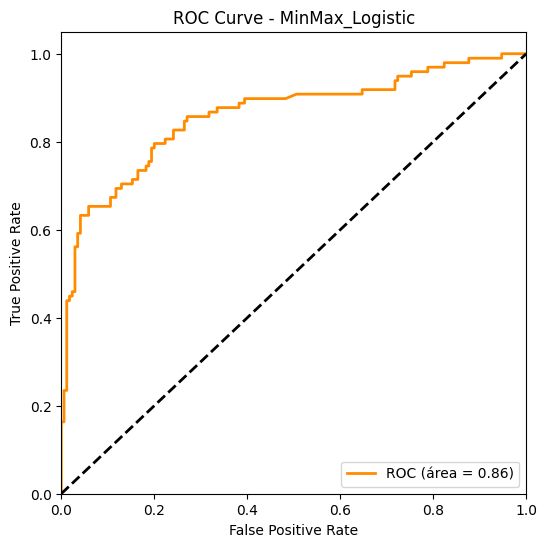


Evaluando modelo MinMax_SGD (2/6)
Accuracy: 0.799


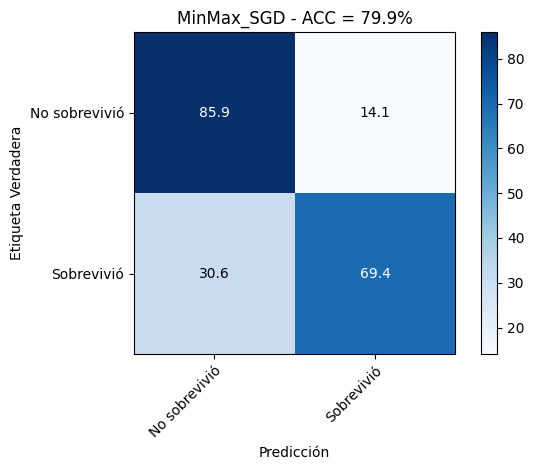

               precision    recall  f1-score   support

No sobrevivió       0.83      0.86      0.84       170
   Sobrevivió       0.74      0.69      0.72        98

     accuracy                           0.80       268
    macro avg       0.78      0.78      0.78       268
 weighted avg       0.80      0.80      0.80       268



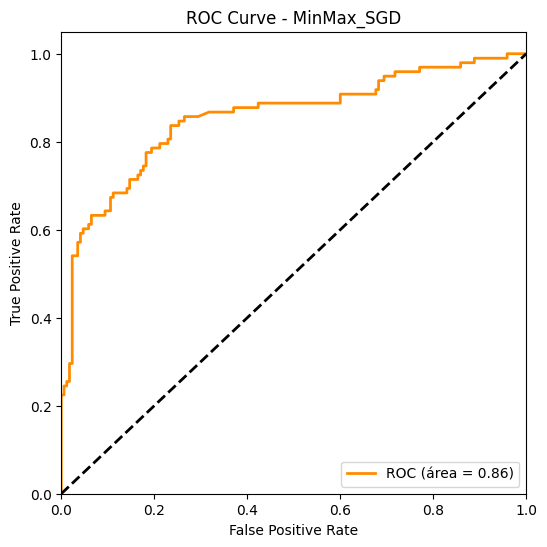


Evaluando modelo MinMax_SVCrbf (3/6)
Accuracy: 0.843


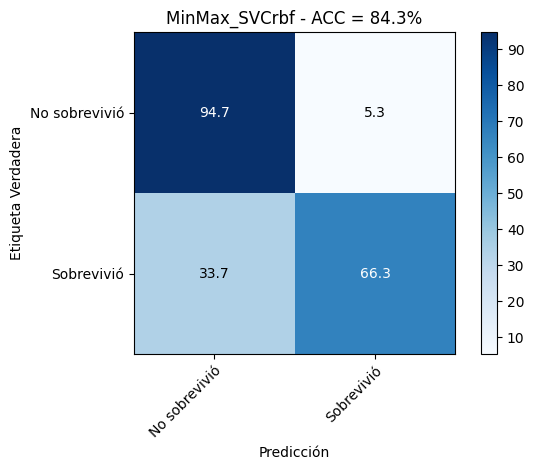

               precision    recall  f1-score   support

No sobrevivió       0.83      0.95      0.88       170
   Sobrevivió       0.88      0.66      0.76        98

     accuracy                           0.84       268
    macro avg       0.85      0.81      0.82       268
 weighted avg       0.85      0.84      0.84       268



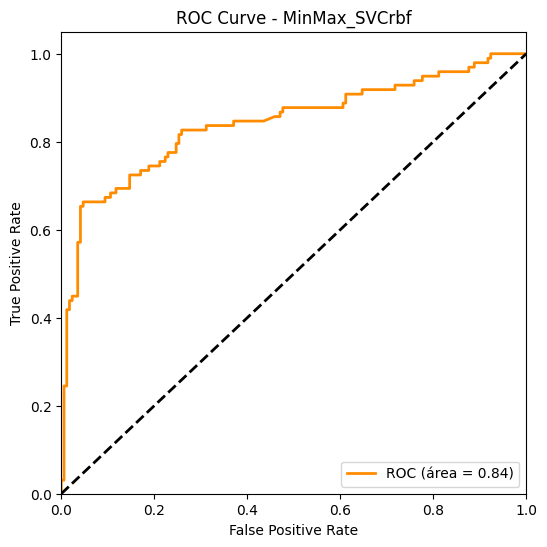


Evaluando modelo MinMax_KNeighbors (4/6)
Accuracy: 0.828


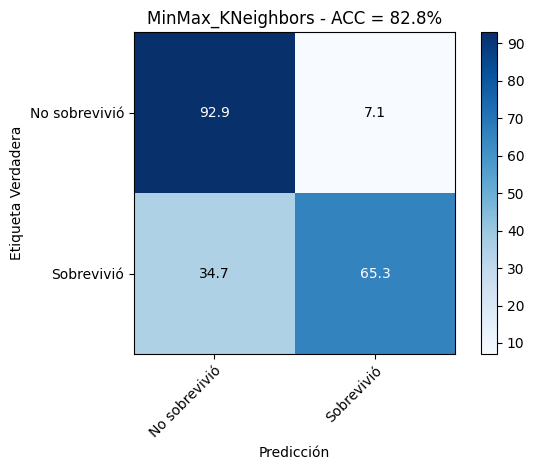

               precision    recall  f1-score   support

No sobrevivió       0.82      0.93      0.87       170
   Sobrevivió       0.84      0.65      0.74        98

     accuracy                           0.83       268
    macro avg       0.83      0.79      0.80       268
 weighted avg       0.83      0.83      0.82       268



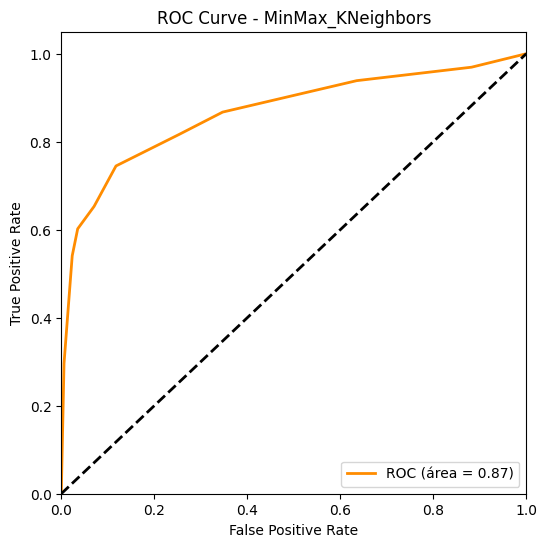


Evaluando modelo MinMax_LDA (5/6)
Accuracy: 0.802


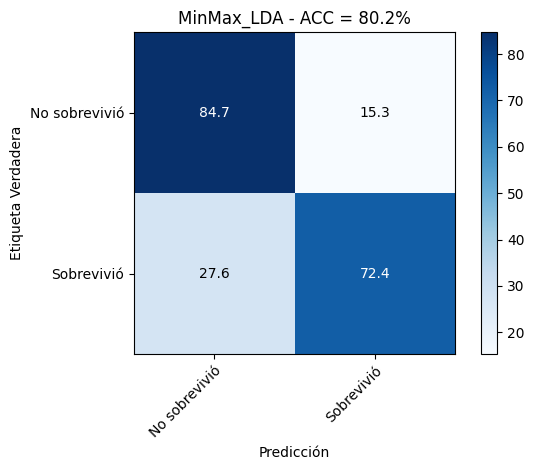

               precision    recall  f1-score   support

No sobrevivió       0.84      0.85      0.84       170
   Sobrevivió       0.73      0.72      0.73        98

     accuracy                           0.80       268
    macro avg       0.79      0.79      0.79       268
 weighted avg       0.80      0.80      0.80       268



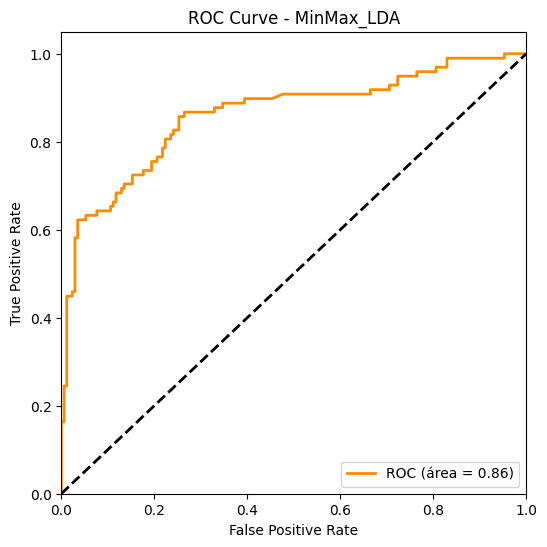


Evaluando modelo MinMax_RandomForest (6/6)
Accuracy: 0.840


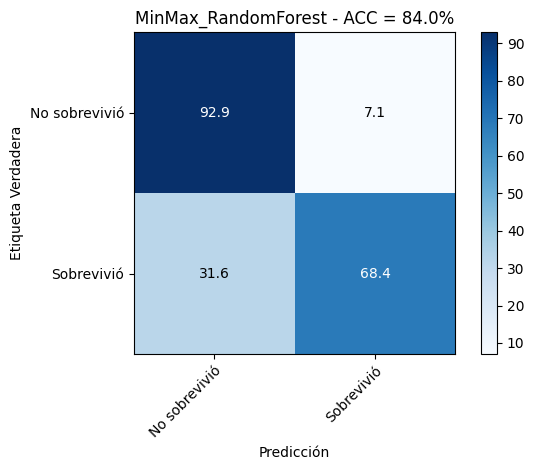

               precision    recall  f1-score   support

No sobrevivió       0.84      0.93      0.88       170
   Sobrevivió       0.85      0.68      0.76        98

     accuracy                           0.84       268
    macro avg       0.84      0.81      0.82       268
 weighted avg       0.84      0.84      0.84       268



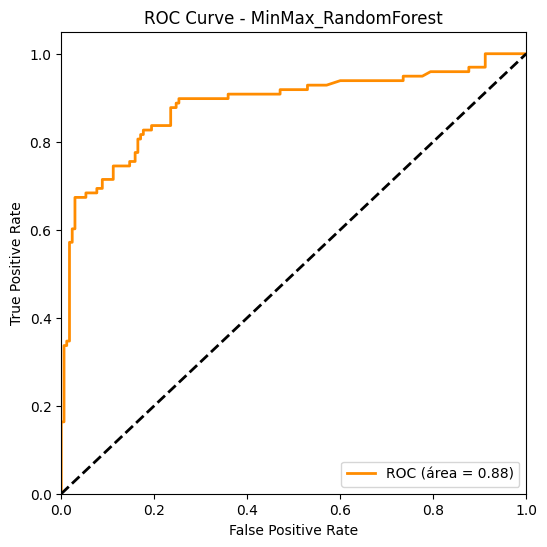

In [26]:
#Clases
unique_classes = np.unique(ytest)
class_names = np.array(['No sobrevivió', 'Sobrevivió'])
binary_task = (len(unique_classes) == 2)

# Binarización para ROC
ytrain_b = label_binarize(ytrain, classes=unique_classes)
ytest_b = label_binarize(ytest, classes=unique_classes)

#Evaluación general sobre Xtest
for i, model in enumerate(my_model_loaded):
    name = label_models[i] if i < len(label_models) else f"Modelo_{i+1}"
    print(f"\nEvaluando modelo {name} ({i+1}/{n_models})")
    best_est = model.best_estimator_

    # ===== PREDICCIÓN =====
    y_pred = best_est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)
    print(f"Accuracy: {acc:.3f}")

    # ===== MATRIZ DE CONFUSIÓN =====
    plot_confusion_matrix(
        ytest, y_pred,
        classes=class_names,
        title=f"{name} - ACC = {100*acc:.1f}%")
    plt.show()

    # ===== REPORTE =====
    print(classification_report(ytest, y_pred, target_names=class_names))

    # ===== CURVA ROC =====
    try:
        if hasattr(best_est, "predict_proba"):
            y_score = best_est.predict_proba(Xtest)
        elif hasattr(best_est, "decision_function"):
            y_score = best_est.decision_function(Xtest)
        else:
            raise AttributeError("Modelo no soporta predict_proba ni decision_function.")

        if binary_task:
            # Binario
            if y_score.ndim > 1:
                y_score = y_score[:, 1]
            fpr, tpr, _ = roc_curve(ytest, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,
                     label=f'ROC (área = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title(f"ROC Curve - {name}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multiclase
            roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, y_score)
            roc_auc_mc(roc_auc, fpr, tpr, n_classes, f'ROC curve {name}', path_img)
    except Exception as e:
        print(f"No se pudo calcular la ROC para {name}: {e}")